In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as layers
import tensorflow.contrib.distributions as ds

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
config = tf.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8, \
                        allow_soft_placement=True, device_count = {'CPU': 8})
sess = tf.InteractiveSession(config = config)

In [4]:
target_loc = 3
target_scale = 0.8

In [5]:
eps = 1e-10

In [6]:
def prepare_data(n_samples):
    data = []
    labels = []
    nuisances = []
    
    for i in range(n_samples):
        sig_bkg = np.random.uniform(low = 0.0, high = 1.0, size = 1)
        if sig_bkg > 0.5:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [0.0, nuisance], cov = np.array([[1, -0.5], [-0.5, 1]]), size = 1).flatten())
            labels.append(1.0)
        else:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [1.0, nuisance], cov = np.eye(2), size = 1).flatten())
            labels.append(0.0)
            
        nuisances.append(nuisance)
    data = np.array(data)
    labels = np.array(labels)
    nuisances = np.array(nuisances)
    
    return data, labels, nuisances.flatten()

In [7]:
num_samples = 100000
data_train, labels_train, nuisances_train = prepare_data(num_samples)
nuisances_train = np.expand_dims(nuisances_train, axis = 1)
labels_train = np.expand_dims(labels_train, axis = 1)

In [17]:
train_bkg = labels_train == 0
bkg_data_train = data_train[train_bkg.flatten()]
bkg_labels_train = labels_train[train_bkg.flatten()]

In [19]:
train_sig = labels_train == 1
sig_data_train = data_train[train_sig.flatten()]
sig_labels_train = labels_train[train_sig.flatten()]

In [20]:
def classifier(data_in, name):
    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
        lay = layers.relu(data_in, 40)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)

    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)

    return outputs, these_vars

In [21]:
def EM_network(data, name):
    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):       
        lay = layers.relu(data, 40)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)
    
    return outputs, these_vars

In [22]:
def make_EM_loss(data_P, data_Q, name):
    local_EM_network_name = name + "_EM_net"
    
    # generator output
    T_P, EM_vars = EM_network(data_P, name = local_EM_network_name)
    
    # target
    T_Q, _ = EM_network(data_Q, name = local_EM_network_name)

    EM_loss = tf.reduce_mean(T_P, axis = 0) - tf.reduce_mean(T_Q, axis = 0)
    
    batch_size_dyn = tf.cast(tf.shape(T_P)[0], tf.int32)
    rand = tf.random.uniform(shape = (batch_size_dyn, 1), minval = 0.0, maxval = 1.0)
    
    # add gradient penalty
    x_grad = tf.math.add(tf.math.multiply(rand, data_P),
                         tf.math.multiply(tf.math.subtract(1.0, rand), data_Q))
    x_grad_EM, _ = EM_network(x_grad, name = local_EM_network_name)
    grad = tf.gradients(x_grad_EM, x_grad)[0]
    
    grad_norm = tf.math.sqrt(tf.reduce_sum(tf.math.square(grad), axis = 1) + eps)
    
    grad_pen = tf.reduce_mean(tf.math.square(grad_norm - 1.0))

    EM_loss_grad_pen = EM_loss[0] + 10 * grad_pen

    return EM_loss_grad_pen, EM_vars, -EM_loss

In [23]:
def make_plots():
    target_test = np.random.normal(loc = target_loc, scale = target_scale, size = (1000, 1))
    inds = np.random.choice(len(data_train), batch_size)
    data_batch = data_train[inds]
    class_output_test = sess.run(class_out,  feed_dict = {data_in: data_batch})
    
    plt.clf()
    plt.hist([np.squeeze(target_test), np.squeeze(class_output_test)], label = ['target', 'generator'], histtype = 'step', density = True, bins = 50)
    plt.xlim([-1, 5])
    plt.ylim([0, 3])
    plt.legend()

In [24]:
data_in = tf.placeholder(tf.float32, [None, 2], name = 'data_in')
target_in = tf.placeholder(tf.float32, [None, 1], name = 'target_in')
labels_in = tf.placeholder(tf.float32, [None, 1], name = 'labels_in')

In [25]:
class_out, gen_vars = classifier(data_in, "gen")

In [26]:
bkg_truth = tf.where(tf.math.less(labels_in, 1))

In [52]:
class_out_bkg = tf.gather_nd(class_out, bkg_truth)
class_out_bkg = tf.expand_dims(class_out_bkg, axis = 1)

In [53]:
EM_lossval, EM_vars, EM_dist = make_EM_loss(class_out_bkg, target_in, "EM_loss_obj")

In [54]:
train_EM = tf.train.AdamOptimizer(learning_rate = 0.01, beta1 = 0.0, beta2 = 0.5).minimize(EM_lossval, var_list = EM_vars)

In [55]:
train_gen = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.0, beta2 = 0.5).minimize(EM_dist, var_list = gen_vars)

In [72]:
sess.run(tf.global_variables_initializer())

In [73]:
init_critic = tf.variables_initializer(EM_vars)

In [74]:
sess.run(init_critic)

In [75]:
batch_size = 1000

In [76]:
for i in range(200):
    target = np.random.normal(loc = target_loc, scale = target_scale, size = (batch_size, 1))
    inds = np.random.choice(len(bkg_data_train), batch_size)
    data_batch = bkg_data_train[inds]
    labels_batch = bkg_labels_train[inds]
    
    sess.run(train_EM, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch})

    EM_dist_val = sess.run(EM_dist, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch})
    print("EM_dist = {}".format(EM_dist_val))

EM_dist = [0.48231593]
EM_dist = [0.8809836]
EM_dist = [1.3438917]
EM_dist = [1.7963531]
EM_dist = [2.3160834]
EM_dist = [2.747621]
EM_dist = [3.088494]
EM_dist = [3.337567]
EM_dist = [3.4945016]
EM_dist = [3.8423731]
EM_dist = [3.4342387]
EM_dist = [4.0654845]
EM_dist = [3.2401087]
EM_dist = [4.0944824]
EM_dist = [3.3862917]
EM_dist = [4.1257296]
EM_dist = [3.3330324]
EM_dist = [4.10738]
EM_dist = [3.33686]
EM_dist = [4.0418506]
EM_dist = [3.4544895]
EM_dist = [4.115942]
EM_dist = [3.388836]
EM_dist = [4.0449753]
EM_dist = [3.362161]
EM_dist = [4.031206]
EM_dist = [3.3979783]
EM_dist = [4.019992]
EM_dist = [3.4649966]
EM_dist = [4.1384296]
EM_dist = [3.4180913]
EM_dist = [4.0358553]
EM_dist = [3.4708252]
EM_dist = [4.1013947]
EM_dist = [3.4019933]
EM_dist = [4.021979]
EM_dist = [3.396811]
EM_dist = [4.0429177]
EM_dist = [3.3959508]
EM_dist = [3.9946234]
EM_dist = [3.4239132]
EM_dist = [4.034388]
EM_dist = [3.424184]
EM_dist = [4.053059]
EM_dist = [3.3852308]
EM_dist = [4.0869517]
EM_d

In [77]:
# compare initial distributions
target_test = np.random.normal(loc = target_loc, scale = target_scale, size = (1000, 1))
inds = np.random.choice(len(data_train), batch_size)
data_batch = data_train[inds]
class_output_test = sess.run(class_out,  feed_dict = {data_in: data_batch})

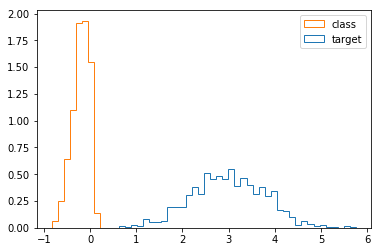

In [78]:
plt.hist([np.squeeze(target_test), np.squeeze(class_output_test)], label = ['target', 'class'], histtype = 'step', density = True, bins = 50)
plt.legend()
plt.show()

In [ ]:
for i in range(0, 800):
    # prepare noise
    for j in range(250):
        target = np.random.normal(loc = target_loc, scale = target_scale, size = (batch_size, 1))
        inds = np.random.choice(len(bkg_data_train), batch_size)
        bkg_batch_data = bkg_data_train[inds]
        bkg_batch_labels = bkg_labels_train[inds]
        
        sess.run(train_EM, feed_dict = {data_in: bkg_batch_data, target_in: target, labels_in: bkg_batch_labels})
    
    target = np.random.normal(loc = target_loc, scale = target_scale, size = (int(batch_size / 2), 1))
    inds = np.random.choice(len(data_train), batch_size)
    data_batch = data_train[inds]
    
    inds_bkg = np.random.choice(len(bkg_data_train), int(batch_size / 2))
    bkg_batch_data = bkg_data_train[inds_bkg]
    bkg_batch_labels = bkg_labels_train[inds_bkg]

    inds_sig = np.random.choice(len(sig_data_train), int(batch_size / 2))
    sig_batch_data = sig_data_train[inds_sig]
    sig_batch_labels = sig_labels_train[inds_sig]

    data_batch = np.concatenate([sig_batch_data, bkg_batch_data])
    labels_batch = np.concatenate([sig_batch_labels, bkg_batch_labels])

    sess.run(train_gen, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch})
    EM_dist_val = sess.run(EM_dist, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch})
    critic_loss = sess.run(EM_lossval, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch})

    print("W = {}".format(EM_dist_val))
    print("critic loss = {}".format(critic_loss))
    
    #save_plots("WGAN_training/epoch_" + str(i).zfill(5) + ".png")

W = [3.9264297]
critic loss = -3.416257381439209
W = [3.960438]
critic loss = -3.4619593620300293
W = [3.9726346]
critic loss = -3.506592273712158
W = [3.95437]
critic loss = -3.5002193450927734
W = [3.895618]
critic loss = -3.4512178897857666
W = [3.9018419]
critic loss = -3.473156690597534
W = [3.852683]
critic loss = -3.440791368484497
W = [3.904016]
critic loss = -3.5010101795196533
W = [3.8940744]
critic loss = -3.4780712127685547
W = [3.7789793]
critic loss = -3.3651466369628906
W = [3.8329005]
critic loss = -3.437039852142334
W = [3.839501]
critic loss = -3.442192316055298
W = [3.8123667]
critic loss = -3.4158878326416016
W = [3.7744944]
critic loss = -3.3663289546966553
W = [3.77826]
critic loss = -3.3808481693267822
W = [3.8083036]
critic loss = -3.4168968200683594
W = [3.6980968]
critic loss = -3.3054072856903076
W = [3.8029222]
critic loss = -3.4133408069610596
W = [3.8202024]
critic loss = -3.4137589931488037
W = [3.825568]
critic loss = -3.4386136531829834


In [70]:
make_plots()

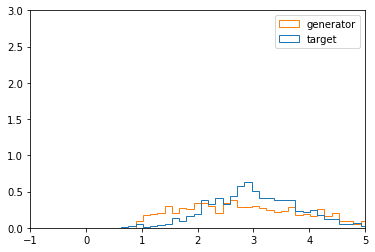

In [71]:
plt.show()